In [3]:
%load_ext autoreload
%autoreload 2
import os
import sys
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
module_path = os.path.abspath("/workspace/categorical_dsm")
if module_path not in sys.path:
    sys.path.append(module_path)
os.chdir(module_path)

In [4]:
import torch
from torchinfo import summary
from torchvision.datasets import VOCSegmentation
from torchvision.models.segmentation import deeplabv3_mobilenet_v3_large, DeepLabV3_MobileNet_V3_Large_Weights
from torchvision.transforms import functional as F, InterpolationMode

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_style("dark")

In [5]:
# from tqdm.auto import tqdm

# for i in tqdm(range(100)):
#     continue

In [6]:
weights = DeepLabV3_MobileNet_V3_Large_Weights.DEFAULT
model = deeplabv3_mobilenet_v3_large(weights=weights)
model.eval()

DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride

In [7]:
print(summary(model))

Layer (type:depth-idx)                             Param #
DeepLabV3                                          --
├─IntermediateLayerGetter: 1-1                     --
│    └─Conv2dNormActivation: 2-1                   --
│    │    └─Conv2d: 3-1                            432
│    │    └─BatchNorm2d: 3-2                       32
│    │    └─Hardswish: 3-3                         --
│    └─InvertedResidual: 2-2                       --
│    │    └─Sequential: 3-4                        464
│    └─InvertedResidual: 2-3                       --
│    │    └─Sequential: 3-5                        3,440
│    └─InvertedResidual: 2-4                       --
│    │    └─Sequential: 3-6                        4,440
│    └─InvertedResidual: 2-5                       --
│    │    └─Sequential: 3-7                        10,328
│    └─InvertedResidual: 2-6                       --
│    │    └─Sequential: 3-8                        20,992
│    └─InvertedResidual: 2-7                       --
│    │ 

In [21]:
!du -sh /home/amahmood/.cache/torch/hub/checkpoints/*

43M	/home/amahmood/.cache/torch/hub/checkpoints/deeplabv3_mobilenet_v3_large-fc3c493d.pth


In [36]:
!du -sh /tmp/datasets/VOCdevkit/VOC2012/*

69M	/tmp/datasets/VOCdevkit/VOC2012/Annotations
9.4M	/tmp/datasets/VOCdevkit/VOC2012/ImageSets
1.9G	/tmp/datasets/VOCdevkit/VOC2012/JPEGImages
14M	/tmp/datasets/VOCdevkit/VOC2012/SegmentationClass
14M	/tmp/datasets/VOCdevkit/VOC2012/SegmentationObject


In [8]:
transforms = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.transforms()
transforms

SemanticSegmentation(
    resize_size=[520]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [9]:
def preprocessing(img, target):
    img = transforms(img)
    size = F.get_dimensions(img)[1:]
    target = F.resize(target, size, interpolation=InterpolationMode.NEAREST)
    return img, F.pil_to_tensor(target)

In [10]:
categories = DeepLabV3_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1.meta['categories']
categories

['__background__',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

In [11]:
dataset = VOCSegmentation(root="/tmp/datasets/", download=False, image_set="val", transforms=None)
dataset

Dataset VOCSegmentation
    Number of datapoints: 1449
    Root location: /tmp/datasets/

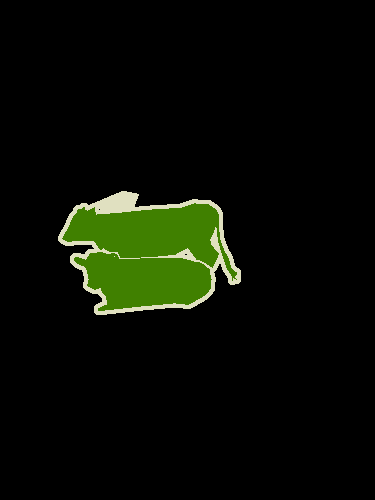

In [12]:
img_x, img_y = dataset[11]
img_y

In [11]:
x, y = preprocessing(img_x, img_y)
x.shape, y.shape

(torch.Size([3, 693, 520]), torch.Size([1, 693, 520]))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


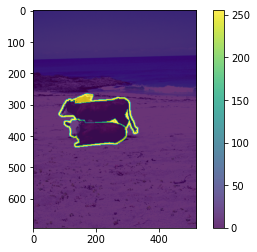

In [12]:
plt.imshow((x.permute(1, 2, 0)+1) / 2)
plt.imshow(y.permute(1, 2, 0), alpha=0.8, cmap="viridis")
plt.colorbar()

In [13]:
y.unique()

tensor([  0,  10, 255], dtype=torch.uint8)

In [26]:
color_map().shape

(256, 3)

['__background__', 'cow']

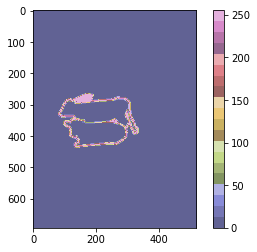

In [28]:
# """ 
# Python implementation of the color map function for the PASCAL VOC data set. 
# Official Matlab version can be found in the PASCAL VOC devkit 
# http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#devkit
# """
# import numpy as np
# from skimage.io import imshow
# import matplotlib.pyplot as plt

# def color_map(N=256, normalized=False):
#     def bitget(byteval, idx):
#         return ((byteval & (1 << idx)) != 0)

#     dtype = 'float32' if normalized else 'uint8'
#     cmap = np.zeros((N, 3), dtype=dtype)
#     for i in range(N):
#         r = g = b = 0
#         c = i
#         for j in range(8):
#             r = r | (bitget(c, 0) << 7-j)
#             g = g | (bitget(c, 1) << 7-j)
#             b = b | (bitget(c, 2) << 7-j)
#             c = c >> 3

#         cmap[i] = np.array([r, g, b])

#     cmap = cmap/255 if normalized else cmap
#     return cmap

plt.imshow(y.permute(1, 2, 0), alpha=0.8, cmap="tab20b")
plt.colorbar()
[categories[c] for c in y.unique() if c != 255]

In [29]:
%%time
with torch.inference_mode():
    out = model(x.unsqueeze(0))
out.keys()

CPU times: user 813 ms, sys: 56.4 ms, total: 869 ms
Wall time: 103 ms


odict_keys(['out', 'aux'])

In [30]:
out["out"][0].shape

torch.Size([21, 693, 520])

In [31]:
seg = out["out"][0].argmax(0)
seg.shape

torch.Size([693, 520])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


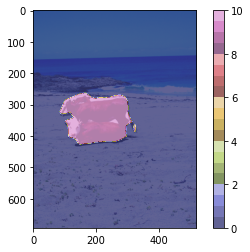

In [32]:
plt.imshow((x.permute(1, 2, 0)+1) / 2)
plt.imshow(seg, alpha=0.8, cmap="tab20b")
plt.colorbar()

In [ ]:
[categories[c] for c in seg.unique()]

['__background__', 'cow']

In [37]:
class ConfusionMatrix:
    '''
    Taken from torchvision reference 
    '''
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.mat = None

    def update(self, a, b):
        n = self.num_classes
        if self.mat is None:
            self.mat = torch.zeros((n, n), dtype=torch.int64, device=a.device)
        with torch.inference_mode():
            k = (a >= 0) & (a < n) # ignore index=255 which belongs to void class
            inds = n * a[k].to(torch.int64) + b[k]
            self.mat += torch.bincount(inds, minlength=n**2).reshape(n, n)

    def reset(self):
        self.mat.zero_()

    def compute(self):
        h = self.mat.float()
        acc_global = torch.diag(h).sum() / h.sum()
        acc = torch.diag(h) / h.sum(1)
        iu = torch.diag(h) / (h.sum(1) + h.sum(0) - torch.diag(h))
        return acc_global, acc, iu

    def reduce_from_all_processes(self):
        reduce_across_processes(self.mat)

    def __str__(self):
        acc_global, acc, iu = self.compute()
        return ("global correct: {:.1f}\naverage row correct: {}\nIoU: {}\nmean IoU: {:.1f}").format(
            acc_global.item() * 100,
            [f"{i:.1f}" for i in (acc * 100).tolist()],
            [f"{i:.1f}" for i in (iu * 100).tolist()],
            iu.mean().item() * 100,
        )
confmat = ConfusionMatrix(num_classes=len(categories))

In [38]:
y_labels = y.flatten()
seg_labels = seg.flatten()
confmat.update(y_labels, seg_labels)
print(confmat)

global correct: 99.4
average row correct: ['99.6', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', '95.4', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
IoU: ['99.3', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', '90.8', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan', 'nan']
mean IoU: nan


In [39]:
y.dtype, seg.dtype, out['out'].dtype

(torch.uint8, torch.int64, torch.float32)

In [40]:
loss = torch.nn.functional.cross_entropy(out['out'], y.long(), ignore_index=255, reduction="none")
loss.mean(dim=(1,2))

tensor([0.0135])

In [41]:
%%time
cross_entropy_scores = []
confmat = ConfusionMatrix(num_classes=len(categories))

for x_batch, target in dataset:
    x_batch, target = preprocessing(x_batch, target)
    x_batch = x_batch.unsqueeze(0)

    with torch.inference_mode():
        out = model(x_batch)["out"]
    seg = out.argmax(1)
    y_labels = target.flatten()
    seg_labels = seg.flatten()
    confmat.update(y_labels, seg_labels)

    loss = torch.nn.functional.cross_entropy(out, target.long(), ignore_index=255, reduction="none")
    loss = loss.mean(dim=(1,2))
    cross_entropy_scores.append(loss.item())

CPU times: user 29min 56s, sys: 1min 2s, total: 30min 59s
Wall time: 3min 8s


In [44]:
print(confmat)

global correct: 93.5
average row correct: ['96.0', '93.1', '84.4', '92.8', '86.2', '77.0', '95.3', '82.3', '95.1', '53.7', '94.6', '60.9', '87.9', '89.4', '94.5', '92.0', '70.1', '89.8', '72.1', '93.4', '71.4']
IoU: ['92.7', '87.6', '37.1', '86.3', '66.0', '68.6', '90.3', '73.2', '87.0', '39.1', '86.3', '47.6', '81.2', '83.5', '84.2', '83.6', '54.9', '80.3', '52.5', '89.1', '64.0']
mean IoU: 73.1


In [49]:
pascal_scores = np.array([l.item() for l in cross_entropy_scores])
np.mean(pascal_scores), np.std(pascal_scores)

(0.18197406701849012, 0.26459004255160923)

In [51]:
np.savez_compressed("./deeplab_v3_pascal_val_xentropy.npz",pascal_scores)

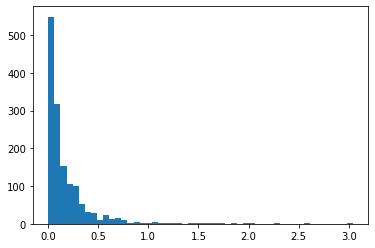

In [54]:
plt.hist(pascal_scores, bins=50);

In [58]:
sorted_idxs = np.argsort(pascal_scores)[::-1]
pascal_scores[sorted_idxs[:5]]

array([3.03852177, 2.58504438, 2.30841875, 2.02411103, 1.95864034])

In [64]:
# import display frok ipywidgets
from IPython.display import display

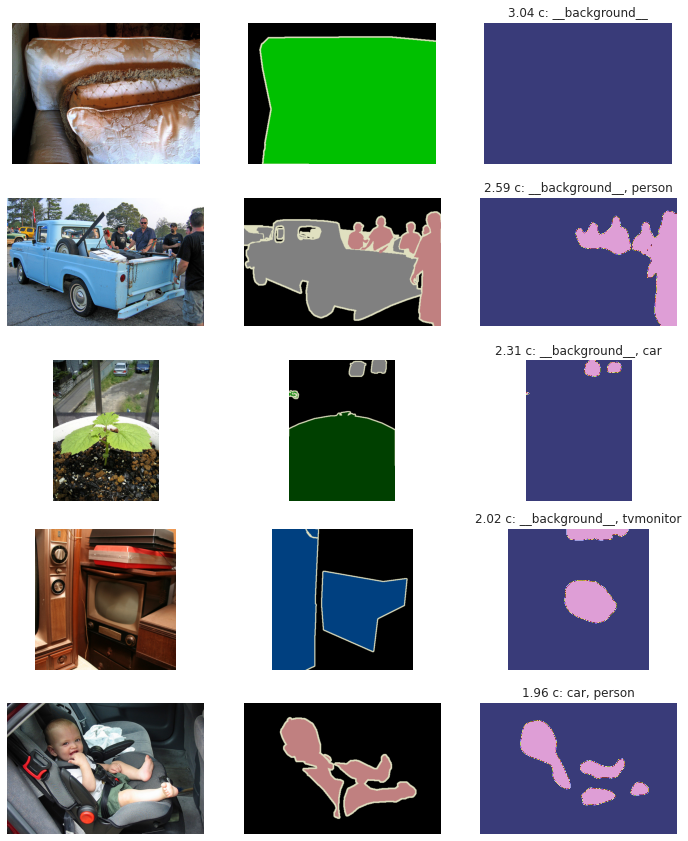

In [108]:
N = 5
fig, axs = plt.subplots(N, 3, figsize=(12, 3*N))

for i in range(N):
    x_batch, target = dataset[sorted_idxs[i]]
    axs[i, 0].imshow(x_batch)
    axs[i, 1].imshow(target)

    x_batch, target = preprocessing(x_batch, target)
    x_batch = x_batch.unsqueeze(0)

    with torch.inference_mode():
        out = model(x_batch)["out"][0]

    cats = [categories[c.item()] for c in out.argmax(0).unique().numpy()]
    loss = pascal_scores[sorted_idxs[i]]
    title_str = f"{loss:.2f}" + " c: " + ", ".join(cats)
    
    axs[i, 2].imshow(out.argmax(0), cmap="tab20b")
    axs[i, 2].set_title(title_str)

for ax in axs.flatten():
    ax.axis('off')
    ax.grid(False)


In [104]:
[c.item() for c in out.argmax(0).unique().numpy()]

[7, 15]

In [105]:
[categories[c.item()] for c in out.argmax(0).unique().numpy()]

['car', 'person']

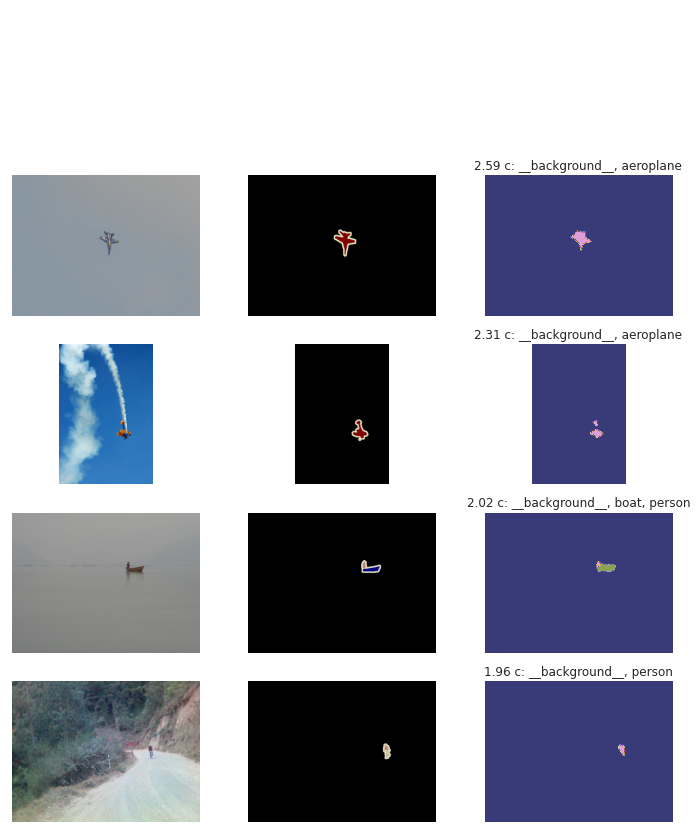

In [109]:
N = 5
fig, axs = plt.subplots(N, 3, figsize=(12, 3*N))

for i in range(1, N):
    x_batch, target = dataset[sorted_idxs[-i]]
    axs[i, 0].imshow(x_batch)
    axs[i, 1].imshow(target)

    x_batch, target = preprocessing(x_batch, target)
    x_batch = x_batch.unsqueeze(0)

    with torch.inference_mode():
        out = model(x_batch)["out"][0]

    cats = [categories[c.item()] for c in out.argmax(0).unique().numpy()]
    loss = pascal_scores[sorted_idxs[i]]
    title_str = f"{loss:.2f}" + " c: " + ", ".join(cats)
    
    axs[i, 2].imshow(out.argmax(0), cmap="tab20b")
    axs[i, 2].set_title(title_str)

for ax in axs.flatten():
    ax.axis('off')
    ax.grid(False)

In [82]:
model_outputs = []

for i in range(10):
    x_batch, target = dataset[i]
    x_batch, target = preprocessing(x_batch, target)
    x_batch = x_batch.unsqueeze(0)

    with torch.inference_mode():
        out = model(x_batch)["out"].numpy()
        model_outputs.append(out)

In [84]:
model_outputs[0].shape

(1, 21, 520, 710)

In [86]:
np.savez_compressed("data/deeplab_v3_pascal_val_seg_out.npz", *model_outputs)

In [74]:
import monai

surf_distance = monai.metrics.compute_average_surface_distance
hauss_distance = monai.metrics.compute_hausdorff_distance

In [58]:
%%time
dist_scores = []

for i in range(100):
    x_batch, target = dataset[i]
    x_batch, target = preprocessing(x_batch, target)
    x_batch = x_batch.unsqueeze(0)

    with torch.inference_mode():
        out = model(x_batch)["out"]
    seg = out.argmax(1)
    
    y = target.clone().long()
    y[y == 255] = 0
    y = torch.nn.functional.one_hot(y, 21).permute(0,3,1,2)
    y_pred = torch.nn.functional.one_hot(seg, 21)
    y_pred = y_pred.permute(0,3,1,2)
    dist_scores.append(surf_distance(y_pred.unsqueeze(0), y.unsqueeze(0) ))
    

CPU times: user 6min 14s, sys: 48.3 s, total: 7min 3s
Wall time: 1min 41s


In [75]:
%%time
hauss_scores = []

for i in range(50):
    x_batch, target = dataset[i]
    x_batch, target = preprocessing(x_batch, target)
    x_batch = x_batch.unsqueeze(0)

    with torch.inference_mode():
        out = model(x_batch)["out"]
    seg = out.argmax(1)
    
    y = target.clone().long()
    y[y == 255] = 0
    y = torch.nn.functional.one_hot(y, 21).permute(0,3,1,2)
    y_pred = torch.nn.functional.one_hot(seg, 21)
    y_pred = y_pred.permute(0,3,1,2)
    hauss_scores.append(hauss_distance(y_pred.unsqueeze(0), y.unsqueeze(0) , percentile=None))

CPU times: user 3min 41s, sys: 30 s, total: 4min 11s
Wall time: 1min 26s


In [76]:
pascal_scores = np.array([l.item() for l in hauss_scores])

In [77]:
sorted_idxs = np.argsort(pascal_scores)[::-1]
pascal_scores[sorted_idxs[:5]]

array([20., 20., 20., 20., 20.])

In [65]:
categories

['__background__',
 'aeroplane',
 'bicycle',
 'bird',
 'boat',
 'bottle',
 'bus',
 'car',
 'cat',
 'chair',
 'cow',
 'diningtable',
 'dog',
 'horse',
 'motorbike',
 'person',
 'pottedplant',
 'sheep',
 'sofa',
 'train',
 'tvmonitor']

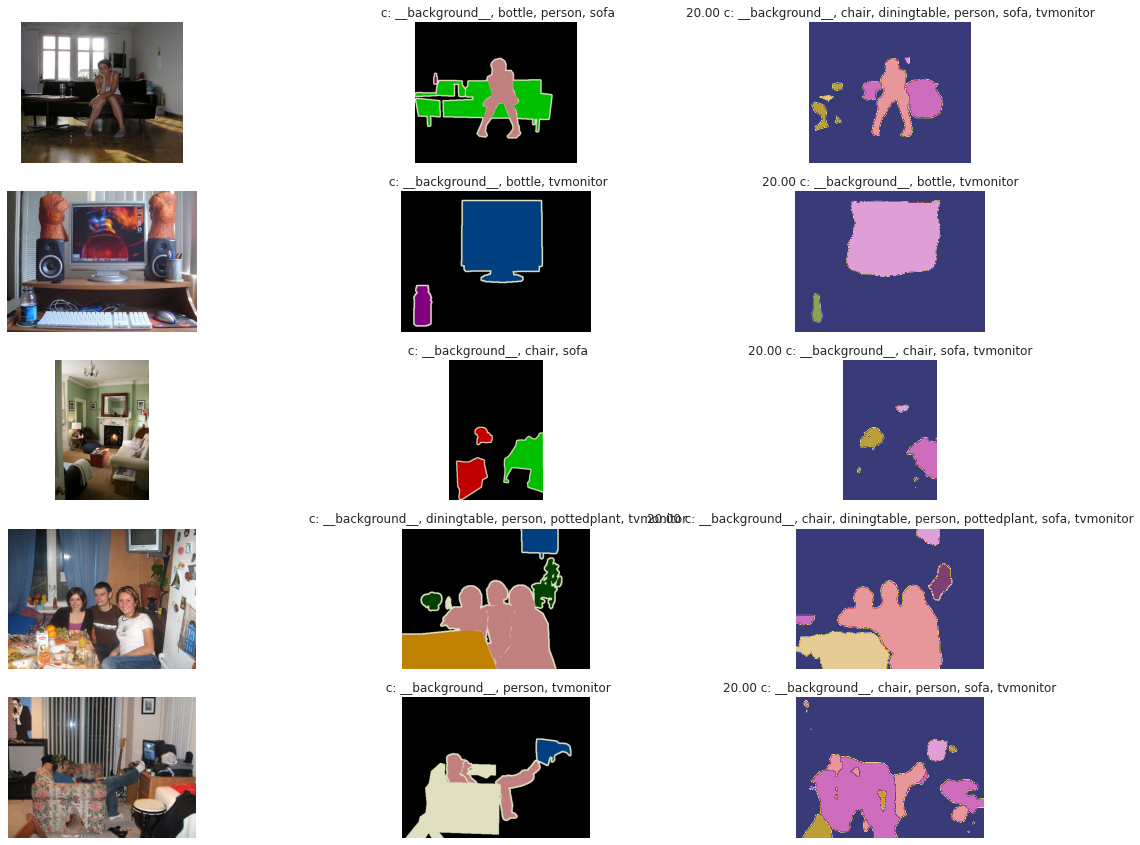

In [78]:
N = 5
fig, axs = plt.subplots(N, 3, figsize=(20, 3*N))

for i in range(N):
    x_batch, target = dataset[sorted_idxs[i]]
    axs[i, 0].imshow(x_batch)
    axs[i, 1].imshow(target)

    x_batch, target = preprocessing(x_batch, target)
    x_batch = x_batch.unsqueeze(0)

    with torch.inference_mode():
        out = model(x_batch)["out"][0]
    
    cats = [categories[c.item()] for c in target.unique().numpy() if c < 255]
    title_str = " c: " + ", ".join(cats)
    axs[i, 1].set_title(title_str)
    
    cats = [categories[c.item()] for c in out.argmax(0).unique().numpy()]
    loss = pascal_scores[sorted_idxs[i]]
    title_str = f"{loss:.2f}" + " c: " + ", ".join(cats)
    
    axs[i, 2].imshow(out.argmax(0), cmap="tab20b")
    axs[i, 2].set_title(title_str)

for ax in axs.flatten():
    ax.axis('off')
    ax.grid(False)


(array([78.,  9.,  8.,  3.,  1.,  0.,  0.,  0.,  0.,  1.]),
 array([0.00841386, 0.82640604, 1.64439822, 2.46239039, 3.28038257,
        4.09837475, 4.91636692, 5.7343591 , 6.55235128, 7.37034345,
        8.18833563]),
 <BarContainer object of 10 artists>)

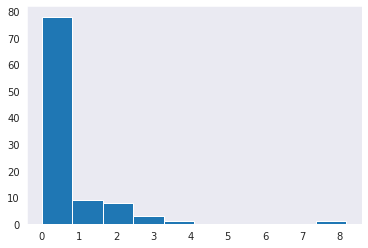

In [73]:
plt.hist(pascal_scores)

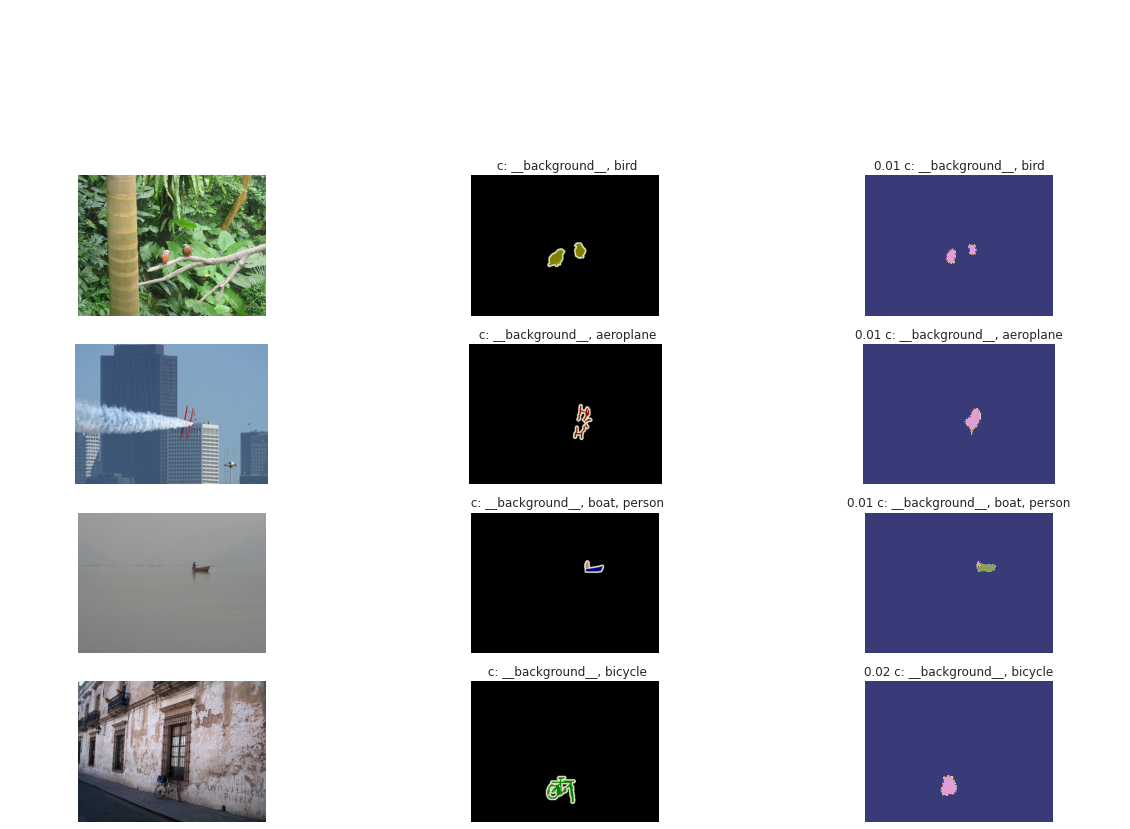

In [72]:
N = 5
fig, axs = plt.subplots(N, 3, figsize=(20, 3*N))

for i in range(1, N):
    x_batch, target = dataset[sorted_idxs[-i]]
    axs[i, 0].imshow(x_batch)
    axs[i, 1].imshow(target)

    x_batch, target = preprocessing(x_batch, target)
    x_batch = x_batch.unsqueeze(0)

    with torch.inference_mode():
        out = model(x_batch)["out"][0]
    
    cats = [categories[c.item()] for c in target.unique().numpy() if c < 255]
    title_str = " c: " + ", ".join(cats)
    axs[i, 1].set_title(title_str)
    
    cats = [categories[c.item()] for c in out.argmax(0).unique().numpy()]
    loss = pascal_scores[sorted_idxs[-i]]
    title_str = f"{loss:.2f}" + " c: " + ", ".join(cats)
    
    axs[i, 2].imshow(out.argmax(0), cmap="tab20b")
    axs[i, 2].set_title(title_str)

for ax in axs.flatten():
    ax.axis('off')
    ax.grid(False)


In [25]:
y_pred = torch.nn.functional.one_hot(seg, 21)
y_pred = y_pred.permute(0,3,1,2)
y_pred.shape

torch.Size([1, 21, 520, 710])

In [40]:
y = target.clone().long()
y[y == 255] = 0
y.shape

torch.Size([1, 520, 710])

In [41]:
y = torch.nn.functional.one_hot(y, 21).permute(0,3,1,2)

In [44]:
surf_distance(y_pred.unsqueeze(0), y.unsqueeze(0) )

tensor([[0.0397]], dtype=torch.float64)